# Anomalous sound detection - Supervised classification of normal/anomalous sounds with neural networks

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gefleury/datascientest_anomalous_sounds/blob/main/notebooks/ASD_supervised_clf_sounds_DL.ipynb) 

In [ ]:
import librosa
import IPython.display as ipd
import librosa.display
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn import preprocessing

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.image import resize
from tensorflow import constant, newaxis

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
#%matplotlib notebook
%matplotlib inline

Install the Gammatone Filterbank Toolkit

In [ ]:
!pip install git+https://github.com/detly/gammatone.git

from gammatone import gtgram

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/detly/gammatone.git to /tmp/pip-req-build-7y84_jxp
  Running command git clone -q https://github.com/detly/gammatone.git /tmp/pip-req-build-7y84_jxp
     |████████████████████████████████| 154 kB 14.6 MB/s 
  Created wheel for Gammatone: filename=Gammatone-1.0-py3-none-any.whl size=21795 sha256=71acdf4c48b05b880712721259019a4e826d23242a1524245f6212d9c4bfefa5
  Stored in directory: /tmp/pip-ephem-wheel-cache-2iaccwxp/wheels/07/b9/a7/356576d1172ea99bf71c5f5502bb20e951769a34b4e86fe6cc
Successfully built Gammatone


Show the gpu infos and change if needed in "Execution" panel

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Jun 30 13:11:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Import data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/DATA_DCASE2022/dev_gearbox.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dev_gearbox')     # create a copy directly in colab for efficiency reasons


Mounted at /content/drive


Function to create dataframes for all machine types containing the filename of each sample, its section, its attribute and type of sound.

In [ ]:
#Constant used throughout the notebook
#PATH_TRAINING_DATASET = r"C:\Users\genef\Desktop\DATA_SCIENTEST\Projet\Dataset_DCASE2022Task2"
PATH_TRAINING_DATASET = r"/content"
#PATH_ADDITIONNAL_DATASET = './Datasets/Additionnal/'

In [ ]:
def build_dataframe(machine_str = 'valve'):
    #Get list of files in train and test directory
    path_train_folder = PATH_TRAINING_DATASET + "/dev_" + machine_str + "/" + machine_str + "/train"
    path_test_folder = PATH_TRAINING_DATASET  + "/dev_" + machine_str + "/" + machine_str + "/test"

    train_files = [f for f in os.listdir(path_train_folder)]
    test_files = [f for f in os.listdir(path_test_folder)]

    #Get list of dictionnary for creating DataFrame
    list_dict_file = []

    #Loop through filenames
    for filename in train_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_train_folder + "/" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.wav')[0]  
        })

    #Loop through filenames
    for filename in test_files:

        #Get filename as list of string
        splitted_filename = filename.split('_')

        #Append dictionnary to list
        list_dict_file.append({
            'filepath' : path_test_folder  + "/" + filename,
            'filename' : filename,
            'section' : int(splitted_filename[1]),
            'domain_env' : splitted_filename[2],
            'dir' : splitted_filename[3],
            'sound_type' : splitted_filename[4],
            'id' : splitted_filename[5],
            'suffix' : '_'.join(splitted_filename[6:]).split('.wav')[0] 
        })
        
    return pd.DataFrame(list_dict_file)


def sound_from_file(filename, machine_str = 'valve', dataset = 'train'):
    df = build_dataframe(machine_str)
    path = PATH_TRAINING_DATASET + "/dev_" + machine_str + "/" + machine_str + "/" + dataset + "/" + filename
    return df[df['filepath']==path].iloc[0]
    

df_gearbox = build_dataframe('gearbox')
df_gearbox.head()

,filepath,filename,section,domain_env,dir,sound_type,id,suffix
0,/content/dev_gearbox/gearbox/train/section_01_...,section_01_source_train_normal_0280_wt_50.wav,1,source,train,normal,0280,wt_50
1,/content/dev_gearbox/gearbox/train/section_02_...,section_02_source_train_normal_0493_id_05.wav,2,source,train,normal,0493,id_05
2,/content/dev_gearbox/gearbox/train/section_00_...,section_00_source_train_normal_0458_volt_3.0.wav,0,source,train,normal,0458,volt_3.0
3,/content/dev_gearbox/gearbox/train/section_02_...,section_02_source_train_normal_0848_id_05.wav,2,source,train,normal,0848,id_05
4,/content/dev_gearbox/gearbox/train/section_00_...,section_00_source_train_normal_0156_volt_2.5.wav,0,source,train,normal,0156,volt_2.5


Function to get the data matrix of amplitude spectrograms and the data matrix of phase spectrograms from a dataframe 

In [ ]:
def load_audio(file_path):
    y, sr = librosa.load(file_path, sr = None)
    return y, sr

def spectrogram(audio, n_fft = 1024, hop_length = 512):
    spectrum = librosa.stft(audio, n_fft = n_fft, hop_length = hop_length, center = False)
    # Chose center = False above after doing a test on a simple superposition of two sin with two frequencies
    # There are boundary artifacts in the spectrograms if center = True
    # Not investigated why it is like this but the spectrograms look definitely better with center = False
    # To be confirmed
    magnitude, phase = librosa.magphase(spectrum)
    magnitude_in_db = librosa.amplitude_to_db(magnitude, ref=1e-6)
    # or ref=np.max. ref = 1e-6 corresponds to the threshold intensity for humans = 1e-12 W/m2
    # Not sure of the units. Does not matter, I just want a fixed ref for all spectrograms
    return magnitude_in_db, np.angle(phase)    

def get_flat_spectros_from_df(df, n_fft = 1024, hop_length = 512):
    def path_to_spectra(path):
        y, sr = load_audio(path)
        mag_sp, phase_sp = spectrogram(y, n_fft = n_fft, hop_length = hop_length)
        return mag_sp.flatten(), phase_sp.flatten()     
    
    filepaths = df['filepath'].reset_index(drop = True)
    X_tmp = path_to_spectra(filepaths.iloc[0])[0]     # to get the size of a flatten spectrum
    X_mag = np.empty((filepaths.shape[0], X_tmp.size))
    X_phase = np.empty((filepaths.shape[0], X_tmp.size))
                   
    for i, path in filepaths.items():
        mag_sp, phase_sp = path_to_spectra(path)
        X_mag[i] = mag_sp
        X_phase[i] = phase_sp

    return X_mag, X_phase

# In contrast with previous notebooks, here I do not flatten the 2D array since we want to feed the CNN with a 2D matrix
def get_2D_spectros_from_df(df, n_fft = 1024, hop_length = 512, compact = False, compact_shape = (32, 32)):
    def path_to_spectra(path):
        y, sr = load_audio(path)
        mag_sp, phase_sp = spectrogram(y, n_fft = n_fft, hop_length = hop_length)
        return mag_sp, phase_sp    
    
    filepaths = df['filepath'].reset_index(drop = True)
    
                   
    for s, path in filepaths.items():
        mag_sp, phase_sp = path_to_spectra(path)

        if compact:
            # Resize to images of size 'compact_shape'
            X_mag = np.empty((filepaths.shape[0], *compact_shape, 1))
            X_phase = np.empty((filepaths.shape[0], *compact_shape, 1))

            img_mag = constant(mag_sp)
            img_phase = constant(phase_sp)
            img_mag = img_mag[:, :, newaxis]
            img_phase = img_phase[:, :, newaxis]
            X_mag[s] = resize(img_mag, compact_shape)
            X_phase[s] = resize(img_phase, compact_shape)

        else:
            X_tmp = path_to_spectra(filepaths.iloc[0])[0]     # to get the size of a spectrum
            X_mag = np.empty((filepaths.shape[0], *X_tmp.shape))
            X_phase = np.empty((filepaths.shape[0], *X_tmp.shape))

            X_mag[s] = mag_sp
            X_phase[s] = phase_sp

    return X_mag, X_phase


# Same for amplitude mel spectrograms
def get_2D_mel_spectros_from_df(df, n_fft = 1024, hop_length = 512, n_mels = 32, compact = False, compact_shape = (32, 32)):
    def get_mel_spectrum_from_path(path):
        y, sr = load_audio(path)
        M = librosa.feature.melspectrogram(y, sr = sr, n_fft = n_fft, hop_length = hop_length, n_mels = n_mels, \
                                           center = False)
        M_db = librosa.power_to_db(M, ref=1e-12)   # or ref=np.max
        return M_db   

    filepaths = df['filepath'].reset_index(drop = True)
            
    for s, path in filepaths.items():
        mag_sp = get_mel_spectrum_from_path(path)

        if compact:
            # Resize to images of size 'compact_shape'
            X_mag = np.empty((filepaths.shape[0], *compact_shape, 1))
            img_mag = constant(mag_sp)
            img_mag = img_mag[:, :, newaxis]
            X_mag[s] = resize(img_mag, compact_shape, method = 'nearest')

        else:
            X_tmp = get_mel_spectrum_from_path(filepaths.iloc[0])     # to get the size of a spectrum
            X_mag = np.empty((filepaths.shape[0], *X_tmp.shape))
            X_mag[s] = mag_sp

    return X_mag

# Get 2D amplitude spectrums with a Gammatone filterbank
# Inspired from https://towardsdatascience.com/human-like-machine-hearing-with-ai-1-3-a5713af6e2f8
# window_time = 0.064 = 1024/16000 (1024 was chosen for n_fft and 16000 is the sampling rate)
# hop_time = window_time / 2
# channels = 32   # Number of rows (in frequency)
def get_2D_gt_spectros_from_df(df, window_time = 0.064, hop_time = 0.032, channels = 32, f_min = 0, \
                               compact = False, compact_shape = (32, 32)):
    def get_gt_spectrum_from_path(path):
        y, sr = load_audio(path)
        mag_sp = gtgram.gtgram(y, sr, window_time, hop_time, channels, f_min)
        return mag_sp    
    
    filepaths = df['filepath'].reset_index(drop = True)
           
    for s, path in filepaths.items():
        mag_sp = get_gt_spectrum_from_path(path)

        if compact:
            # Resize to images of size 'compact_shape'
            X_mag = np.empty((filepaths.shape[0], *compact_shape, 1))
            img_mag = constant(mag_sp)
            img_mag = img_mag[:, :, newaxis]
            X_mag[s] = resize(img_mag, compact_shape, method = "nearest")

        else:
            X_tmp = get_gt_spectrum_from_path(filepaths.iloc[0])     # to get the size of a spectrum
            X_mag = np.empty((filepaths.shape[0], *X_tmp.shape))
            X_mag[s] = mag_sp

    return X_mag


#X_mag, X_phase = get_spectros_from_df(df_gearbox[(df_gearbox['dir']=='test') & (df_gearbox['section']==0)])



## Choose data

In [ ]:
# Choose the machine
machine_str = 'gearbox'

# Fix the parameters
params = dict(n_fft = 1024,        # n_fft paramater for calculating the spectrograms with librosa.stft
              hop_length = 512     # hop_length paramater for calculating the spectrograms with librosa.stft
             )

In [ ]:
df = build_dataframe(machine_str)

df_normal = df[df['sound_type']=='normal'].sample(n = 500, random_state = 1)
df_anormal = df[df['sound_type']=='anomaly'].sample(n = 300, random_state = 1)
data = pd.concat([df_normal, df_anormal], axis = 0).reset_index()

X_mag, X_phase = get_2D_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'], \
                                         compact = True, compact_shape = (32, 32))

target = data['sound_type']
target = target.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

Choose randomly one spectrum and compare with its compact version

In [ ]:
X_mag1, X_phase1 = get_2D_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'], \
                                         compact = False)

X_mag2, X_phase2 = get_2D_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'], \
                                         compact = True, compact_shape = (32, 32))




(800, 513, 311)
(800, 32, 32, 1)


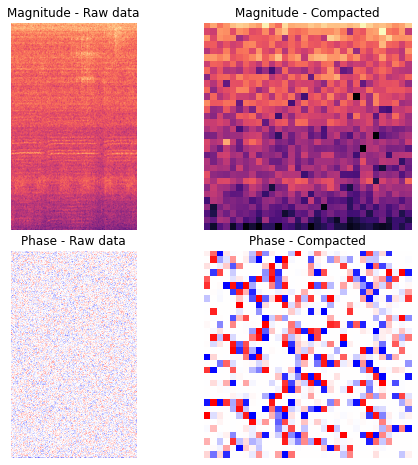

In [ ]:
print(X_phase1.shape)
print(X_phase2.shape)

compact_shape = (32, 32)
np.random.seed(100)
for i in np.random.choice(X_mag1.shape[0], 1):
    fig = plt.figure(figsize = (8, 8))
    gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1, height_ratios=None, figure=fig)  

    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(X_mag1[i].reshape((X_mag1[i].shape[0], X_mag1[i].shape[1])), cmap = 'magma')
    ax.axis('off')
    ax.set_title('Magnitude - Raw data')

    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(X_mag2[i].reshape(compact_shape), cmap = 'magma')
    ax.axis('off')
    ax.set_title('Magnitude - Compacted')

    ax = fig.add_subplot(gs[1, 0])
    #print(X_phase1[i].min(), X_phase1[i].max())
    ax.imshow(X_phase1[i].reshape((X_phase1[i].shape[0], X_phase1[i].shape[1])), cmap = 'bwr')
    ax.axis('off')
    ax.set_title('Phase - Raw data')

    ax = fig.add_subplot(gs[1, 1])
    #print(X_phase2[i].min(), X_phase2[i].max())
    ax.imshow(X_phase2[i].reshape(compact_shape), cmap = 'bwr')
    ax.axis('off')
    ax.set_title('Phase - Compacted')

Do the same for images compacted to 64x64 

In [ ]:
X_mag1, X_phase1 = get_2D_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'], \
                                         compact = False)

X_mag2, X_phase2 = get_2D_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'], \
                                         compact = True, compact_shape = (64, 64))

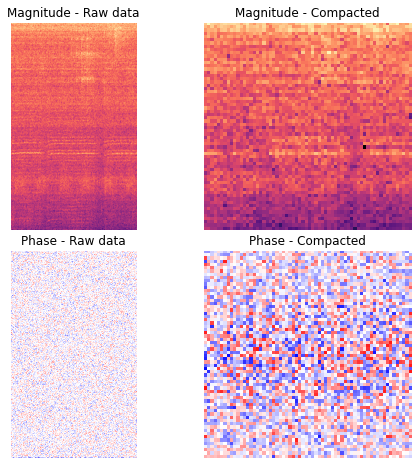

In [ ]:
np.random.seed(100)
for i in np.random.choice(X_mag1.shape[0], 1):
    fig = plt.figure(figsize = (8, 8))
    gs = gridspec.GridSpec(2, 2, wspace=0.1, hspace=0.1, height_ratios=None, figure=fig)  

    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(X_mag1[i].reshape((X_mag1[i].shape[0], X_mag1[i].shape[1])), cmap = 'magma')
    ax.axis('off')
    ax.set_title('Magnitude - Raw data')

    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(X_mag2[i].reshape((64, 64)), cmap = 'magma')
    ax.axis('off')
    ax.set_title('Magnitude - Compacted')

    ax = fig.add_subplot(gs[1, 0])
    ax.imshow(X_phase1[i].reshape((X_phase1[i].shape[0], X_phase1[i].shape[1])), cmap = 'bwr')
    ax.axis('off')
    ax.set_title('Phase - Raw data')

    ax = fig.add_subplot(gs[1, 1])
    ax.imshow(X_phase2[i].reshape((64, 64)), vmin = -np.pi, vmax = np.pi, cmap = 'bwr')
    ax.axis('off')
    ax.set_title('Phase - Compacted')

## Split in training and test sets

In [ ]:
# Choose here if the training is done on the amplitude spectrogram, phase spectrogram or both
which = 'amplitude'      # 'amplitude', 'phase', or 'both'

In [ ]:
def my_train_test_split(X_mag, X_phase, target, which = 'amplitude', test_size = 0.2, random_state = 123):
    if which == 'amplitude':
        X = X_mag
    elif which == 'phase':
        X = X_phase
    elif which == 'both':
        X = np.concatenate([X_mag, X_phase], axis = 1)
    else:
        raise ValueError("'which' must be equal to 'amplitude', 'phase' or 'both'")
        
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = test_size, random_state = random_state)
    
    return X_train, X_test, y_train, y_test


In [ ]:
X_train, X_test, y_train, y_test = my_train_test_split(X_mag, X_phase, target, which = which)

print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (640, 32, 32, 1)
X_test shape =  (160, 32, 32, 1)


## Normalize, reshape (and encode the target if needed)

In [ ]:
def normalize_reshape_encode(X_train, X_test, y_train, y_test, to_cat = False):
    # This part could be written more elegantly with keras.layers.Normalization()

    # Flatten the spectrograms to be allowed to use Standard Scaler
    train_shape_0 = X_train.shape
    test_shape_0 = X_test.shape
    X_train = X_train.reshape((train_shape_0[0], train_shape_0[1]*train_shape_0[2]))
    X_test = X_test.reshape((test_shape_0[0], test_shape_0[1]*test_shape_0[2]))

    # Scale data
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Shape to 2D spectrograms again
    X_train = X_train.reshape((-1, train_shape_0[1], train_shape_0[2], 1))
    X_test = X_test.reshape((-1, test_shape_0[1], test_shape_0[2], 1))

    # One Hot Encoding of the target ( eg if loss = 'categorical_crossentropy' is used later)
    if to_cat:
        y_train = to_categorical(y_train)
        y_test = to_categorical(y_test)

    return X_train, X_test, y_train, y_test



In [ ]:
X_train, X_test, y_train, y_test = normalize_reshape_encode(X_train, X_test, y_train, y_test, to_cat = False)
print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (640, 32, 32, 1)
X_test shape =  (160, 32, 32, 1)


## Machine learning

In [ ]:
# LeNet architecture with parameters taken from the course 
def build_lenet_model(shape):
    
    inputs = Input(shape = shape, name = "Input")

    first_layer = Conv2D(filters = 30, kernel_size = (5, 5), padding = 'valid', activation ='relu')
    second_layer = MaxPooling2D(pool_size = (2, 2))
    third_layer = Conv2D(filters = 16, kernel_size = (3, 3), padding = 'valid', activation ='relu')
    fourth_layer = MaxPooling2D(pool_size = (2, 2))
    fifth_layer = Dropout(rate = 0.2)
    sixth_layer = Flatten()
    seventh_layer = Dense(units = 128, activation = 'relu')
    output_layer = Dense(units = 1, activation = 'softmax')        

    x = first_layer(inputs)
    x = second_layer(x)
    x = third_layer(x)
    x = fourth_layer(x)
    x = fifth_layer(x)
    x = sixth_layer(x)
    x = seventh_layer(x)
    outputs = output_layer(x)

    model = Model(inputs = inputs, outputs = outputs)
    
    return model

In [ ]:
lenet_model = build_lenet_model(X_train.shape[1:])
lenet_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
training_history_lenet = lenet_model.fit(X_train, y_train, batch_size = 64, epochs = 30, validation_split = 0.2)

Epoch 1/30
8/8 [==============================] - 1s 37ms/step - loss: nan - accuracy: 0.6055 - val_loss: nan - val_accuracy: 0.7031
Epoch 2/30
8/8 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.6055 - val_loss: nan - val_accuracy: 0.7031
Epoch 3/30
8/8 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.6055 - val_loss: nan - val_accuracy: 0.7031
Epoch 4/30
8/8 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.6055 - val_loss: nan - val_accuracy: 0.7031
Epoch 5/30
8/8 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.6055 - val_loss: nan - val_accuracy: 0.7031
Epoch 6/30
8/8 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.6055 - val_loss: nan - val_accuracy: 0.7031
Epoch 7/30
8/8 [==============================] - 0s 8ms/step - loss: nan - accuracy: 0.6055 - val_loss: nan - val_accuracy: 0.7031
Epoch 8/30
8/8 [==============================] - 0s 8ms/step - loss: nan -

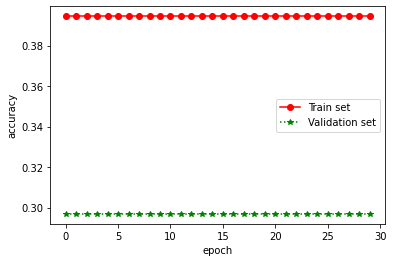

In [ ]:
plt.plot(training_history_lenet.history['accuracy'], 'r-o', label = "Train set")
plt.plot(training_history_lenet.history['val_accuracy'], 'g:*', label = "Validation set")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

Damn, this is really bad! The model doesn't learn anything. Let's try with some callback functions.

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 5, mode = 'min', verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 3, factor = 0.1, cooldown = 4, verbose = 1)

lenet_model = build_lenet_model(X_train.shape[1:])
lenet_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
training_history_lenet = lenet_model.fit(X_train, y_train, batch_size = 64, epochs = 30, validation_split = 0.2, \
                                         callbacks = [early_stopping, reduce_learning_rate])

Epoch 1/30
8/8 [==============================] - 1s 39ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 4/30
1/8 [==>...........................] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4062
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
8/8 [==============================] - 0s 9ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 0.0010
Epoch 5/30
8/8 [==============================] - 0s 10ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 1.0000e-04
Epoch 6/30
8/8 [=====================

Not better! The loss function is zero, it look's like we are trapped in a local minimum. Let's try with larger learning rates.

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 5, mode = 'min', verbose = 1)

def exponential_decay_fn(epoch):
    return 10 * 0.1**(epoch/20)

lr_scheduler = LearningRateScheduler(exponential_decay_fn)

training_history_lenet = lenet_model.fit(X_train, y_train, batch_size = 64, epochs = 30, validation_split = 0.2, \
                                         callbacks = [early_stopping, lr_scheduler])

Epoch 1/30
8/8 [==============================] - 0s 12ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 10.0000
Epoch 2/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 8.9125
Epoch 3/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 7.9433
Epoch 4/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 7.0795
Epoch 5/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 6.3096
Epoch 6/30
8/8 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.3945 - val_loss: 0.0000e+00 - val_accuracy: 0.2969 - lr: 5.6234
Epoch 6: early stopping


Not better. Actually, after reading, the loss function we have considered (categorical_crossentropy) is convex in our binary case. So we are guaranteed to find the global maximum.

I come back to the very beginning. It's actually stupid to feed LeNet with my spectrograms of size 513x311 while LeNet is apparently appropriate for input images of size 32x32. I will re-try after reducing the spectrograms to images of size 32x32 -> after test, it does not help!

## Predict and evaluate

In [ ]:
test_preds = lenet_model.predict(X_test)
train_preds = lenet_model.predict(X_train)

test_preds_class = test_preds.argmax(axis = 1)
train_preds_class = train_preds.argmax(axis = 1)


In [ ]:
test_f1_score_0 = f1_score(y_test, test_preds_class, pos_label = 0)
test_f1_score_1 = f1_score(y_test, test_preds_class, pos_label = 1)
train_f1_score_0 = f1_score(y_train, train_preds_class, pos_label = 0)
train_f1_score_1 = f1_score(y_train, train_preds_class, pos_label = 1)
test_auc = roc_auc_score(y_test, test_preds_class)
train_auc = roc_auc_score(y_train, train_preds_class)

print("f1 score of class 0 on test set = ", np.round(test_f1_score_0, 3))
print("f1 score of class 1 on test set = ", np.round(test_f1_score_1, 3))
print("f1 score of class 0 on train set = ", np.round(train_f1_score_0, 3))
print("f1 score of class 1 on train set = ", np.round(train_f1_score_1, 3))
print("Train AUC = ", np.round(train_auc, 3))
print("Test AUC = ", np.round(test_auc, 3))

#pd.crosstab(y_test.values, test_preds.values, rownames = ['Classe réelle'], colnames = ['Classe prédite'])
pd.crosstab(y_test, test_preds_class, rownames = ['Classe réelle'], colnames = ['Classe prédite'])

f1 score of class 0 on test set =  0.769
f1 score of class 1 on test set =  0.0
f1 score of class 0 on train set =  0.769
f1 score of class 1 on train set =  0.0
Train AUC =  0.5
Test AUC =  0.5


Classe prédite,0
Classe réelle,
0,100
1,60


## Other attempt: with a square magnitude spectrum obtained with gammatone filterbank

Plot some gammatone filtered spectrograms

In [ ]:
# Choose the machine
machine_str = 'gearbox'

# Select sounds randomly
df = build_dataframe(machine_str)

df_normal = df[df['sound_type']=='normal'].sample(n = 20, random_state = 1)
df_anormal = df[df['sound_type']=='anomaly'].sample(n = 20, random_state = 1)
data = pd.concat([df_normal, df_anormal], axis = 0).reset_index()

# Get the spectrums
X_mag1 = get_2D_gt_spectros_from_df(data, channels = 32, compact = False)
X_mag2 = get_2D_gt_spectros_from_df(data, channels = 32, compact = True, compact_shape = (32, 311))
print(X_mag1.shape)
print(X_mag2.shape)



(40, 32, 311)
(40, 32, 311, 1)


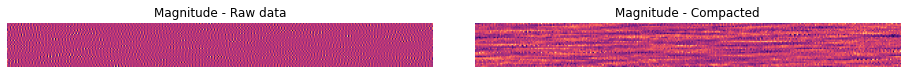

In [ ]:
np.random.seed(10)
for i in np.random.choice(X_mag1.shape[0], 1):
    fig = plt.figure(figsize = (16, 12))
    gs = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1, height_ratios=None, figure=fig)  

    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(X_mag1[i].reshape((X_mag1[i].shape[0], X_mag1[i].shape[1])), cmap = 'magma')
    ax.axis('off')
    ax.set_title('Magnitude - Raw data')

    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(X_mag2[i].reshape((X_mag2[i].shape[0], X_mag2[i].shape[1])), cmap = 'magma')
    ax.axis('off')
    ax.set_title('Magnitude - Compacted')

Results are weird. Obviously there is a problem when the figure is compacted.

### New try by modifying the LeNet model (previous output neuron was wrong)

In [ ]:
# Choose the machine
machine_str = 'gearbox'

# Choose here if the training is done on the amplitude spectrogram, phase spectrogram or both
which = 'amplitude'      # 'amplitude', 'phase', or 'both'

# Fix the parameters
params = dict(n_fft = 1024,        # n_fft paramater for calculating the spectrograms with librosa.stft
              hop_length = 512     # hop_length paramater for calculating the spectrograms with librosa.stft
             )

# Select data
df = build_dataframe(machine_str)

df_normal = df[df['sound_type']=='normal'].sample(n = 500, random_state = 1)
df_anormal = df[df['sound_type']=='anomaly'].sample(n = 300, random_state = 1)
#df_normal = df[(df['sound_type']=='normal') & (df['section']==0)].sample(n = 150, random_state = 1)
#df_anormal = df[(df['sound_type']=='anomaly') & (df['section']==0)].sample(n = 100, random_state = 1)
data = pd.concat([df_normal, df_anormal], axis = 0).reset_index()

# Build the spectrograms
X_mag, X_phase = get_2D_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'], \
                                         compact = False, compact_shape = (32, 32))

# Isolate the target
target = data['sound_type']
target = target.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

# Split in train and test sets
X_train, X_test, y_train, y_test = my_train_test_split(X_mag, X_phase, target, which = which)
print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (640, 513, 311)
X_test shape =  (160, 513, 311)


In [ ]:
y_train = y_train.values
y_test = y_test.values

In [ ]:
# More preprocessing
X_train, X_test, y_train, y_test = normalize_reshape_encode(X_train, X_test, y_train, y_test, to_cat = False)
print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (640, 513, 311, 1)
X_test shape =  (160, 513, 311, 1)


Change the last neuron of the LeNet model

https://stackoverflow.com/questions/45793856/binary-classification-with-softmax

In [ ]:
def build_lenet_model_2(shape):
    
    inputs = Input(shape = shape, name = "Input")

    first_layer = Conv2D(filters = 16, kernel_size = (5, 5), padding = 'valid', activation ='relu')
    second_layer = MaxPooling2D(pool_size = (2, 2))
    third_layer = Conv2D(filters = 8, kernel_size = (3, 3), padding = 'valid', activation ='relu')
    fourth_layer = MaxPooling2D(pool_size = (2, 2))
    fifth_layer = Dropout(rate = 0.2)
    sixth_layer = Flatten()
    seventh_layer = Dense(units = 64, activation = 'relu')
    output_layer = Dense(units = 2, activation = 'softmax')        

    x = first_layer(inputs)
    x = second_layer(x)
    x = third_layer(x)
    x = fourth_layer(x)
    x = fifth_layer(x)
    x = sixth_layer(x)
    x = seventh_layer(x)
    outputs = output_layer(x)

    model = Model(inputs = inputs, outputs = outputs)
    
    return model

In [ ]:
# Build the LeNet model and fit
lenet_model = build_lenet_model_2(X_train.shape[1:])
lenet_model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 513, 311, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 509, 307, 16)      416       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 254, 153, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 252, 151, 8)       1160      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 126, 75, 8)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 126, 75, 8)        0   

In [ ]:
lenet_model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
training_history_lenet = lenet_model.fit(X_train, y_train, batch_size = 64, epochs = 30, validation_split = 0.2)

Epoch 1/30
8/8 [==============================] - 1s 110ms/step - loss: 2.8265 - accuracy: 0.5508 - val_loss: 1.2223 - val_accuracy: 0.4844
Epoch 2/30
8/8 [==============================] - 1s 80ms/step - loss: 0.9470 - accuracy: 0.5176 - val_loss: 0.6653 - val_accuracy: 0.5156
Epoch 3/30
8/8 [==============================] - 1s 82ms/step - loss: 0.6799 - accuracy: 0.5859 - val_loss: 0.6679 - val_accuracy: 0.7031
Epoch 4/30
8/8 [==============================] - 1s 82ms/step - loss: 0.6785 - accuracy: 0.6055 - val_loss: 0.6623 - val_accuracy: 0.7031
Epoch 5/30
8/8 [==============================] - 1s 83ms/step - loss: 0.6773 - accuracy: 0.6055 - val_loss: 0.6588 - val_accuracy: 0.7031
Epoch 6/30
8/8 [==============================] - 1s 92ms/step - loss: 0.6774 - accuracy: 0.6055 - val_loss: 0.6612 - val_accuracy: 0.6953
Epoch 7/30
8/8 [==============================] - 1s 82ms/step - loss: 0.6763 - accuracy: 0.6055 - val_loss: 0.6612 - val_accuracy: 0.6953
Epoch 8/30
8/8 [==========

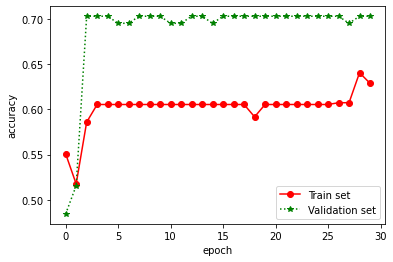

In [ ]:
plt.plot(training_history_lenet.history['accuracy'], 'r-o', label = "Train set")
plt.plot(training_history_lenet.history['val_accuracy'], 'g:*', label = "Validation set")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 5, mode = 'min', verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 3, factor = 0.2, cooldown = 4, verbose = 1)

training_history_lenet = lenet_model.fit(X_train, y_train, batch_size = 64, epochs = 30, validation_split = 0.2, \
                                         callbacks = [early_stopping, reduce_learning_rate])

Epoch 1/30
8/8 [==============================] - 1s 140ms/step - loss: 0.4520 - accuracy: 0.7441 - val_loss: 0.5207 - val_accuracy: 0.7422 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - 1s 125ms/step - loss: 0.4532 - accuracy: 0.7441 - val_loss: 0.5063 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - 1s 118ms/step - loss: 0.4511 - accuracy: 0.7441 - val_loss: 0.5114 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 4/30
8/8 [==============================] - 1s 118ms/step - loss: 0.4473 - accuracy: 0.7441 - val_loss: 0.5077 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 5/30
8/8 [==============================] - ETA: 0s - loss: 0.5040 - accuracy: 0.7051
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
8/8 [==============================] - 1s 126ms/step - loss: 0.5040 - accuracy: 0.7051 - val_loss: 0.5509 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 6/30
8/8 [==============================] - 1s 126ms/step - loss: 0.504

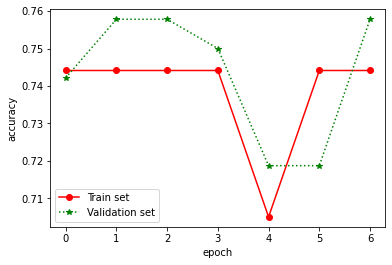

In [ ]:
plt.plot(training_history_lenet.history['accuracy'], 'r-o', label = "Train set")
plt.plot(training_history_lenet.history['val_accuracy'], 'g:*', label = "Validation set")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
test_preds = lenet_model.predict(X_test)
train_preds = lenet_model.predict(X_train)

#test_preds_class = np.where(test_preds>0.5, 1, 0).flatten()
#train_preds_class = np.where(train_preds>0.5, 1, 0).flatten()

test_preds_class = test_preds.argmax(axis = 1)
train_preds_class = train_preds.argmax(axis = 1)


In [ ]:
test_f1_score_0 = f1_score(y_test, test_preds_class, pos_label = 0)
test_f1_score_1 = f1_score(y_test, test_preds_class, pos_label = 1)
train_f1_score_0 = f1_score(y_train, train_preds_class, pos_label = 0)
train_f1_score_1 = f1_score(y_train, train_preds_class, pos_label = 1)
test_auc = roc_auc_score(y_test, test_preds_class)
train_auc = roc_auc_score(y_train, train_preds_class)

print("f1 score of class 0 on test set = ", np.round(test_f1_score_0, 3))
print("f1 score of class 1 on test set = ", np.round(test_f1_score_1, 3))
print("f1 score of class 0 on train set = ", np.round(train_f1_score_0, 3))
print("f1 score of class 1 on train set = ", np.round(train_f1_score_1, 3))
print("Train AUC = ", np.round(train_auc, 3))
print("Test AUC = ", np.round(test_auc, 3))

#pd.crosstab(y_test.values, test_preds.values, rownames = ['Classe réelle'], colnames = ['Classe prédite'])
pd.crosstab(y_test, test_preds_class, rownames = ['Classe réelle'], colnames = ['Classe prédite'])

f1 score of class 0 on test set =  0.803
f1 score of class 1 on test set =  0.31
f1 score of class 0 on train set =  0.827
f1 score of class 1 on train set =  0.473
Train AUC =  0.654
Test AUC =  0.592


Classe prédite,0,1
Classe réelle,,
0,100,0
1,49,11


## Let's try with compacted mel spectrograms and various LeNet models

In [ ]:
# Choose the machine
machine_str = 'gearbox'

# Fix the parameters
params = dict(n_fft = 2048,        # n_fft paramater for calculating the spectrograms with librosa.stft
              hop_length = 1024     # hop_length paramater for calculating the spectrograms with librosa.stft
             )

# Select data
df = build_dataframe(machine_str)

df_normal = df[df['sound_type']=='normal'].sample(n = 500, random_state = 1)
df_anormal = df[df['sound_type']=='anomaly'].sample(n = 300, random_state = 1)
#df_normal = df[(df['sound_type']=='normal') & (df['section']==0)].sample(n = 150, random_state = 1)
#df_anormal = df[(df['sound_type']=='anomaly') & (df['section']==0)].sample(n = 100, random_state = 1)
data = pd.concat([df_normal, df_anormal], axis = 0).reset_index()


In [ ]:
# Get the spectrums
X_mag1 = get_2D_mel_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'], n_mels = 64, \
                                         compact = False)
X_mag2 = get_2D_mel_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'], n_mels = 64, \
                                         compact = True, compact_shape = (64, 311))
print(X_mag1.shape)
print(X_mag2.shape)

(800, 64, 155)
(800, 64, 155, 1)


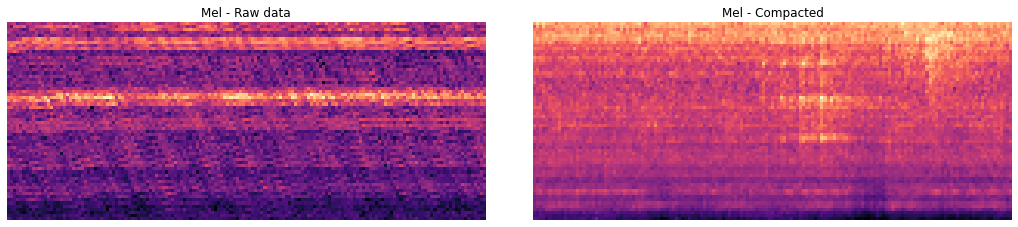

In [ ]:
compact_shape = (64, 155)
np.random.seed(100)
for i in np.random.choice(X_mag1.shape[0], 1):
    fig = plt.figure(figsize = (18, 8))
    gs = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1, height_ratios=None, figure=fig)  

    ax = fig.add_subplot(gs[0, 0])
    ax.imshow(X_mag1[i].reshape((X_mag1[i].shape[0], X_mag1[i].shape[1])), cmap = 'magma')
    ax.axis('off')
    ax.set_title('Mel - Raw data')

    ax = fig.add_subplot(gs[0, 1])
    ax.imshow(X_mag2[i].reshape(compact_shape), cmap = 'magma')
    ax.axis('off')
    ax.set_title('Mel - Compacted')

Even if I resize with the original size for a check, the two images are different. This is probably due to the choice of the method in resize but this is weird. I will not use the resized image below.

In [ ]:
# Build the spectrograms
X = get_2D_mel_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'], n_mels = 64, \
                                         compact = False)

# Isolate the target
target = data['sound_type']
target = target.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

# Split in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, random_state = 1)
print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (640, 64, 155)
X_test shape =  (160, 64, 155)


In [ ]:
# More preprocessing
X_train, X_test, y_train, y_test = normalize_reshape_encode(X_train, X_test, y_train, y_test, to_cat = False)
print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (640, 64, 155, 1)
X_test shape =  (160, 64, 155, 1)


In [ ]:
def build_lenet_model_3(shape):
    
    inputs = Input(shape = shape, name = "Input")

    first_layer = Conv2D(filters = 60, kernel_size = (5, 5), padding = 'valid', activation ='relu')
    second_layer = MaxPooling2D(pool_size = (2, 2))
    third_layer = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation ='relu')
    fourth_layer = MaxPooling2D(pool_size = (2, 2))
    fifth_layer = Dropout(rate = 0.2)
    sixth_layer = Flatten()
    seventh_layer = Dense(units = 64, activation = 'relu')
    output_layer = Dense(units = 1, activation = 'sigmoid')        

    x = first_layer(inputs)
    x = second_layer(x)
    x = third_layer(x)
    x = fourth_layer(x)
    x = fifth_layer(x)
    x = sixth_layer(x)
    x = seventh_layer(x)
    outputs = output_layer(x)

    model = Model(inputs = inputs, outputs = outputs)
    
    return model

In [ ]:
# Build the LeNet model and fit
lenet_model = build_lenet_model_3(X_train.shape[1:])
lenet_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 5, mode = 'min', verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 3, factor = 0.2, cooldown = 4, verbose = 1)

training_history_lenet = lenet_model.fit(X_train, y_train, batch_size = 64, epochs = 30, validation_split = 0.2, \
                                         callbacks = [reduce_learning_rate])

Epoch 1/30
8/8 [==============================] - 1s 36ms/step - loss: 0.7733 - accuracy: 0.5801 - val_loss: 0.6899 - val_accuracy: 0.4844 - lr: 0.0010
Epoch 2/30
8/8 [==============================] - 0s 16ms/step - loss: 0.6877 - accuracy: 0.5000 - val_loss: 0.6854 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/30
8/8 [==============================] - 0s 16ms/step - loss: 0.6857 - accuracy: 0.6387 - val_loss: 0.6819 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/30
6/8 [=====================>........] - ETA: 0s - loss: 0.6808 - accuracy: 0.6328
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
8/8 [==============================] - 0s 17ms/step - loss: 0.6787 - accuracy: 0.6387 - val_loss: 0.6836 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/30
8/8 [==============================] - 0s 16ms/step - loss: 0.6806 - accuracy: 0.6387 - val_loss: 0.6802 - val_accuracy: 0.6250 - lr: 2.0000e-04
Epoch 6/30
8/8 [==============================] - 0s 17ms/step - loss: 0.6772 

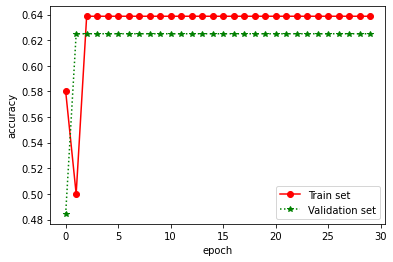

In [ ]:
plt.plot(training_history_lenet.history['accuracy'], 'r-o', label = "Train set")
plt.plot(training_history_lenet.history['val_accuracy'], 'g:*', label = "Validation set")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
test_preds = lenet_model.predict(X_test)
train_preds = lenet_model.predict(X_train)

test_preds_class = np.where(test_preds>0.5, 1, 0).flatten()
train_preds_class = np.where(train_preds>0.5, 1, 0).flatten()

In [ ]:
test_f1_score_0 = f1_score(y_test, test_preds_class, pos_label = 0)
test_f1_score_1 = f1_score(y_test, test_preds_class, pos_label = 1)
train_f1_score_0 = f1_score(y_train, train_preds_class, pos_label = 0)
train_f1_score_1 = f1_score(y_train, train_preds_class, pos_label = 1)
test_auc = roc_auc_score(y_test, test_preds_class)
train_auc = roc_auc_score(y_train, train_preds_class)

print("f1 score of class 0 on test set = ", np.round(test_f1_score_0, 3))
print("f1 score of class 1 on test set = ", np.round(test_f1_score_1, 3))
print("f1 score of class 0 on train set = ", np.round(train_f1_score_0, 3))
print("f1 score of class 1 on train set = ", np.round(train_f1_score_1, 3))
print("Train AUC = ", np.round(train_auc, 3))
print("Test AUC = ", np.round(test_auc, 3))

#pd.crosstab(y_test.values, test_preds.values, rownames = ['Classe réelle'], colnames = ['Classe prédite'])
pd.crosstab(y_test, test_preds_class, rownames = ['Classe réelle'], colnames = ['Classe prédite'])

f1 score of class 0 on test set =  0.735
f1 score of class 1 on test set =  0.0
f1 score of class 0 on train set =  0.777
f1 score of class 1 on train set =  0.0
Train AUC =  0.5
Test AUC =  0.5


Classe prédite,0
Classe réelle,
0,93
1,67


I tried to play with different parameters of the LeNEt model but without success: the model is not able to detect any anomalous sound.

## Come back to PCA reduction method, reshape to 2D, and try LeNet

In [ ]:
# Choose the machine
machine_str = 'gearbox'

# Choose here if the training is done on the amplitude spectrogram, phase spectrogram or both
which = 'amplitude'      # 'amplitude', 'phase', or 'both'

# Fix the parameters
params = dict(n_fft = 1024,        # n_fft paramater for calculating the spectrograms with librosa.stft
              hop_length = 512     # hop_length paramater for calculating the spectrograms with librosa.stft
             )

In [ ]:
df = build_dataframe(machine_str)

df_normal = df[df['sound_type']=='normal'].sample(n = 500, random_state = 1)
df_anormal = df[df['sound_type']=='anomaly'].sample(n = 300, random_state = 1)
data = pd.concat([df_normal, df_anormal], axis = 0).reset_index()

#X_mag, X_phase = get_2D_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'], \
#                                         compact = False)

X_mag, X_phase = get_flat_spectros_from_df(data, n_fft = params['n_fft'], hop_length = params['hop_length'])

target = data['sound_type']
target = target.replace(to_replace = ['normal', 'anomaly'], value = [0, 1])

In [ ]:
X_train, X_test, y_train, y_test = my_train_test_split(X_mag, X_phase, target, which = which)

X_train_shape = X_train.shape
X_test_shape = X_test.shape
print("X_train shape = ", X_train.shape)
print("X_test shape = ", X_test.shape)

X_train shape =  (640, 159543)
X_test shape =  (160, 159543)


I follow the reduction recipe used in the previous notebook

In [ ]:
#X_train = X_train.reshape((X_train_shape[0], X_train_shape[1]*X_train_shape[2]))
#X_test = X_test.reshape((X_test_shape[0], X_test_shape[1]*X_test_shape[2]))

sel = SelectPercentile(score_func = f_classif, percentile = 30)
sel.fit(X_train, y_train)
X_red_train = sel.transform(X_train)
X_red_test = sel.transform(X_test)

In [ ]:
n_feats = X_red_train.shape[1]
pca = PCA(n_components = 0.85)       # keep 85% of variance
pca.fit(X_red_train)
X_red_train = pca.transform(X_red_train)
X_red_test = pca.transform(X_red_test)

print("Number of initial features = ", n_feats)
print("Number of selected features = ", pca.n_components_)

Number of initial features =  47863
Number of selected features =  446


I have only one selected feature in the end with n_components = 0.85!? I don't see why I don't get the same result as the one obtained in the previous notebook. I've used the same seeds. 
-> This is corrected if I play with the flattened spectrograms from the beginning but I don't see why it does not work with the other implementation. No time to investigate.

Now I have 446 features. I want to reshape to 21x21=441 so I remove a few more features.

In [ ]:
sel = SelectKBest(score_func = f_classif, k = 441)
sel.fit(X_red_train, y_train)
X_red_train = sel.transform(X_red_train)
X_red_test = sel.transform(X_red_test)

print("Number of features = ", X_red_train.shape[1])

Number of features =  441


In [ ]:
X_red_train = X_red_train.reshape((X_train_shape[0], 21, 21))
X_red_test = X_red_test.reshape((X_test_shape[0], 21, 21))

In [ ]:
X_red_train, X_red_test, y_train, y_test = normalize_reshape_encode(X_red_train, X_red_test, y_train, y_test, to_cat = False)

In [ ]:
def build_lenet_model_3(shape):
    
    inputs = Input(shape = shape, name = "Input")

    first_layer = Conv2D(filters = 60, kernel_size = (5, 5), padding = 'valid', activation ='relu')
    second_layer = MaxPooling2D(pool_size = (2, 2))
    third_layer = Conv2D(filters = 32, kernel_size = (3, 3), padding = 'valid', activation ='relu')
    fourth_layer = MaxPooling2D(pool_size = (2, 2))
    fifth_layer = Dropout(rate = 0.2)
    sixth_layer = Flatten()
    seventh_layer = Dense(units = 64, activation = 'relu')
    output_layer = Dense(units = 1, activation = 'sigmoid')        

    x = first_layer(inputs)
    x = second_layer(x)
    x = third_layer(x)
    x = fourth_layer(x)
    x = fifth_layer(x)
    x = sixth_layer(x)
    x = seventh_layer(x)
    outputs = output_layer(x)

    model = Model(inputs = inputs, outputs = outputs)
    
    return model

In [ ]:
# Build the LeNet model and fit
lenet_model = build_lenet_model_3(X_red_train.shape[1:])
lenet_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
lenet_model.summary()

early_stopping = EarlyStopping(monitor = 'val_loss', min_delta = 0.01, patience = 5, mode = 'min', verbose = 1)
reduce_learning_rate = ReduceLROnPlateau(monitor = 'val_loss', min_delta = 0.01, patience = 3, factor = 0.2, cooldown = 4, verbose = 1)

training_history_lenet = lenet_model.fit(X_red_train, y_train, batch_size = 64, epochs = 50, validation_split = 0.2, \
                                         callbacks = [reduce_learning_rate])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 21, 21, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 60)        1560      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 60)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 32)          17312     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 3, 3, 32)          0   

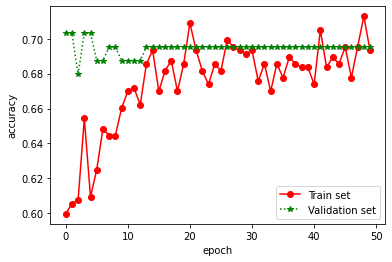

In [ ]:
plt.plot(training_history_lenet.history['accuracy'], 'r-o', label = "Train set")
plt.plot(training_history_lenet.history['val_accuracy'], 'g:*', label = "Validation set")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
test_preds = lenet_model.predict(X_red_test)
train_preds = lenet_model.predict(X_red_train)

test_preds_class = np.where(test_preds>0.5, 1, 0).flatten()
train_preds_class = np.where(train_preds>0.5, 1, 0).flatten()

In [ ]:
test_f1_score_0 = f1_score(y_test, test_preds_class, pos_label = 0)
test_f1_score_1 = f1_score(y_test, test_preds_class, pos_label = 1)
train_f1_score_0 = f1_score(y_train, train_preds_class, pos_label = 0)
train_f1_score_1 = f1_score(y_train, train_preds_class, pos_label = 1)
test_auc = roc_auc_score(y_test, test_preds_class)
train_auc = roc_auc_score(y_train, train_preds_class)

print("f1 score of class 0 on test set = ", np.round(test_f1_score_0, 3))
print("f1 score of class 1 on test set = ", np.round(test_f1_score_1, 3))
print("f1 score of class 0 on train set = ", np.round(train_f1_score_0, 3))
print("f1 score of class 1 on train set = ", np.round(train_f1_score_1, 3))
print("Train AUC = ", np.round(train_auc, 3))
print("Test AUC = ", np.round(test_auc, 3))

#pd.crosstab(y_test.values, test_preds.values, rownames = ['Classe réelle'], colnames = ['Classe prédite'])
#pd.crosstab(y_train, train_preds_class, rownames = ['Classe réelle'], colnames = ['Classe prédite'])
pd.crosstab(y_test, test_preds_class, rownames = ['Classe réelle'], colnames = ['Classe prédite'])

f1 score of class 0 on test set =  0.057
f1 score of class 1 on test set =  0.54
f1 score of class 0 on train set =  0.794
f1 score of class 1 on train set =  0.276
Train AUC =  0.576
Test AUC =  0.498


Classe prédite,0,1
Classe réelle,,
0,3,97
1,2,58
